In [1]:
import numpy as np
#import gym
import sys
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib


%matplotlib inline
#fig, ax = plt.subplots(figsize=(20, 10)) 
#fig, ax = plt.subplots(figsize=(18, 2))
#ax.imshow(random.rand(8, 90), interpolation='nearest')
#tight_layout()

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(20,20)

sys.path.append('../src')
sys.path.append('../src/envs')
sys.path.append('../src/game_generator')
sys.path.append('../src/agents')
sys.path.append('../src/utils')

def showim(buffer):
    fig, ax = plt.subplots(figsize=(9, 9))
    #ax.imshow(random.rand(8, 90), interpolation='nearest')
    ax.imshow(buffer,interpolation='nearest',aspect='auto')

In [2]:

from robot_reboot_extractor import RobotRebootExtractor
from ricochet_env import RicochetEnv
from agent_dqn import DQNAgent
from simulation import Experiment
from utils import helper

Using TensorFlow backend.


In [3]:
agent , env = helper.prepare_game('game0.png')

<IPython.core.display.Javascript object>


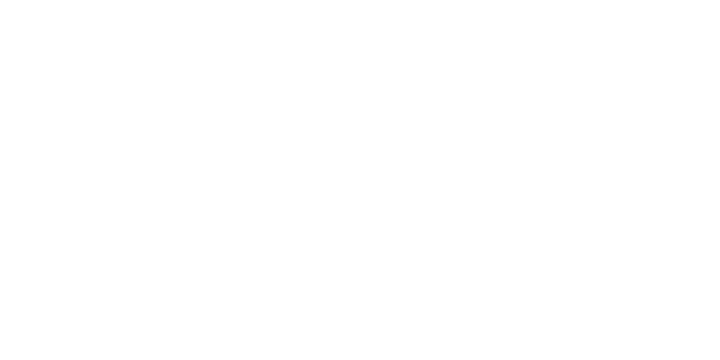

<IPython.core.display.Javascript object>


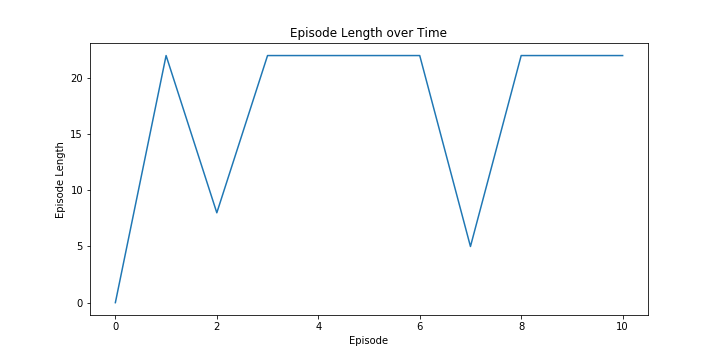

<IPython.core.display.Javascript object>


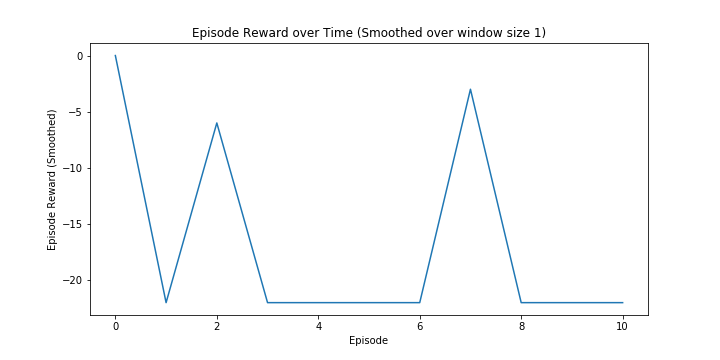

In [4]:
interactive = True
%matplotlib nbagg

#agent = DQNAgent(8 , 4*4)
agent = DQNAgent(8 , 4)

experiment = Experiment(env, agent)

#experiment.run_agent( max_number_of_episodes=5, max_number_of_steps=100, interactive = True, display_frequency=1)#
experiment.run_qlearning( max_number_of_episodes=10,  interactive = False, display_frequency=1)

In [11]:
from keras import backend as K

model = agent.model
trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
non_trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 916
Trainable params: 916
Non-trainable params: 0


In [5]:
import helper


In [6]:
helper.save_model(agent.model)

Saved model to disk


In [3]:
im = Image.open( '../games/game1.png').convert('RGB')

In [4]:
im.size

(642, 642)

In [5]:
agent = DQNAgent(8 , 4)

In [6]:
rre = RobotRebootExtractor(im)

In [7]:
env = RicochetEnv(rre)
env.reset()

[[1, 2], [13, 0], [11, 11], [7, 13]]

In [9]:
buffer = env.render(mode='rgb_array')

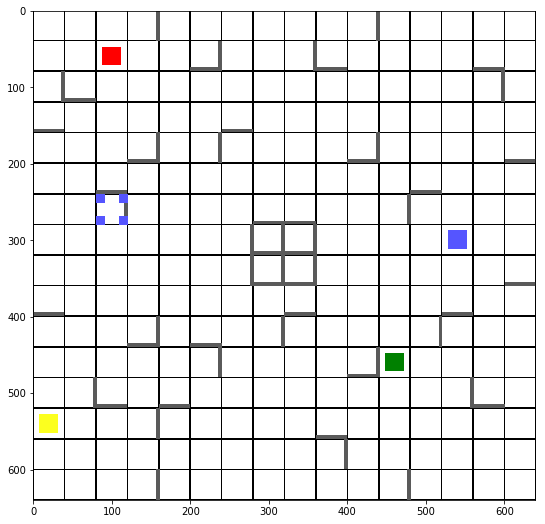

In [9]:
showim(buffer)

In [11]:
env.step( env.encode_action( 'r' , 'N') )

([[0, 2], [13, 0], [11, 11], [7, 13]], -1, False, '')

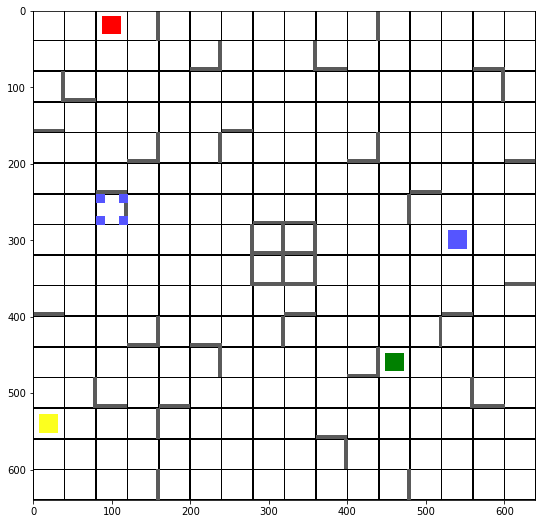

In [12]:
showim( buffer = env.render() )

([[0, 2], [13, 0], [11, 11], [13, 9]], -1, False, '')

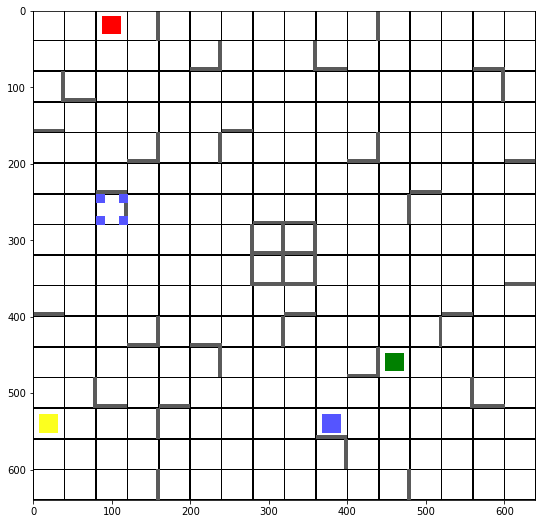

In [14]:
state = env.step( env.encode_action( 'b' , 'S') )
showim( buffer = env.render() )
state

In [8]:
rre.goal

(6, 2, 'b')

In [ ]:
%load_ext autoreload

In [17]:

%autoreload 2

[[1, 2], [13, 0], [11, 11], [7, 13]]


In [5]:
def prepare_game(img_file='game1.png'):
    im = Image.open( '../games/' + img_file).convert('RGB')
    agent = DQNAgent(8 , 4)
    rre = RobotRebootExtractor(im)
    env = RicochetEnv(rre)
    
    return agent , env

In [6]:
agent , env = prepare_game()

<IPython.core.display.Javascript object>


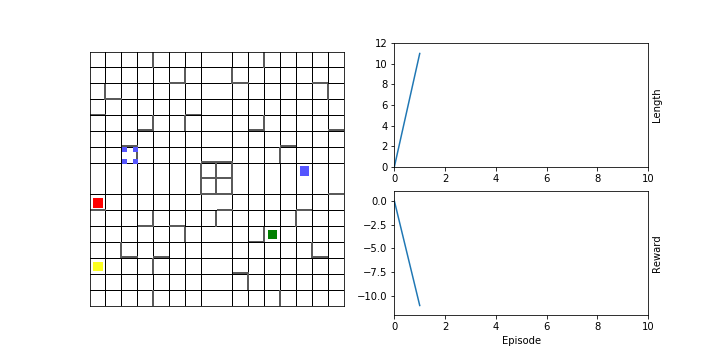

too many steps. Stopped


In [7]:
interactive = True
%matplotlib nbagg

experiment = Experiment(env, agent)

experiment.run_agent( max_number_of_episodes=1, max_number_of_steps=10, interactive = True, display_frequency=1)

In [28]:
import collections
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import numpy as np
import random

# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = collections.deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        print('act =============  ' + str(self.epsilon))
        
        
        if np.random.rand() <= self.epsilon:
            action = random.randrange(self.action_size)
            print(action)
            return action
        
        print(' act state')
        #print( state )
        state = state.reshape( [1, 8])
        act_values = self.model.predict(state)
        
        #print('aaa')
        print(act_values)
        action = np.argmax(act_values[0])  # returns action
        return action


    def learn(self, state, action, reward, next_state, done):
        #print('state')
        #print(state)
        #print('next state')
        #print(next_state)
        state = state.reshape( [1, 8])
        next_state = next_state.reshape( [1, 8])
        self.remember(state, action, reward, next_state, done)
        self.replay(batch_size = 16)

    def replay(self, batch_size):
        if len( self.memory ) < batch_size :
            return 

        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            target = reward
            
            next_state = next_state.reshape( [1, 8])
            print('target: ' + str(target))
            if not done:
                print('kkkkkkkkkkkkkkk')
                print('state')
                print(state)
                print('predicct')
                
                
                print('new next state')
                print(next_state)
                
                predict_next_state_action_values = self.model.predict(next_state)
                
                max_next_state_action_value = np.amax( predict_next_state_action_values[0] )
                
                print(predict_next_state_action_values)
                print(max_next_state_action_value)
                target = reward + self.gamma * max_next_state_action_value

            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



<IPython.core.display.Javascript object>


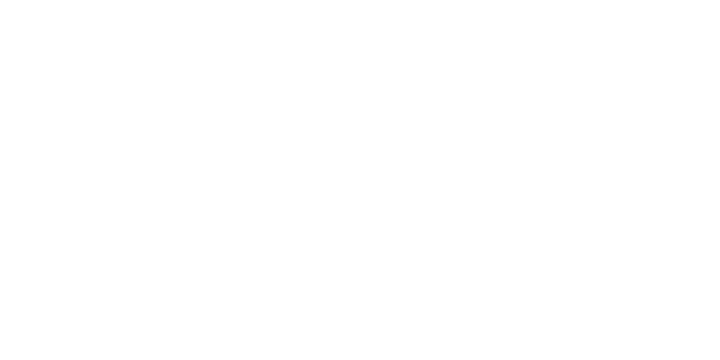

act =============  1.0
3
act =============  1.0
15
act =============  1.0
11
act =============  1.0
12
act =============  1.0
3
act =============  1.0
0
act =============  1.0
6
act =============  1.0
8
act =============  1.0
13
act =============  1.0
10
act =============  1.0
11
act =============  1.0
10
act =============  1.0
0
act =============  1.0
9
act =============  1.0
5
act =============  1.0
6
target: -1
kkkkkkkkkkkkkkk
state
[[ 0  0 11 15 13 14  5  6]]
predicct
new next state
[[ 0  0 11 15 13 14  5  6]]
[[-0.5030209   7.2782884  -2.6078625   3.7794998   1.0931765   5.046959
   1.9980476   0.52366316  0.40218925  0.5736337  -2.1422238  -5.0744977
   1.4983538   3.7930193  -8.717448   -0.3661944 ]]
7.2782884
target: -1
kkkkkkkkkkkkkkk
state
[[ 0  0 11 15 13 14  5  6]]
predicct
new next state
[[ 0  0 11 15 13 14  5  6]]
[[-0.46930182  7.3071666  -2.7539744   4.09981     1.0442718   4.979336
   2.0390508   0.582162    0.25632563  0.5925824  -2.2354627  -5.1088133
   1.5257478   

target: -1
kkkkkkkkkkkkkkk
state
[[ 0  3 11 12 13 14  5  6]]
predicct
new next state
[[ 0  3 11 12 13 14  5  6]]
[[ 2.2569485   6.351287   -1.219152    4.6648965  -1.1914252   5.1959386
   3.7347763  -0.81137955  3.432325    1.9288695  -0.14731914 -1.9936337
   0.22754753  4.9985948  -6.116435   -0.9041058 ]]
6.351287
target: -1
kkkkkkkkkkkkkkk
state
[[ 0  3 11 12 13 14  5  6]]
predicct
new next state
[[ 0  3 11 12 13 14  5  6]]
[[ 2.3261623   6.3724675  -1.1865151   4.686119   -1.2358174   5.18488
   3.742853   -0.85945165  3.5134048   1.9053056  -0.02786398 -1.9366153
   0.19195418  5.0480933  -6.085219   -0.92672634]]
6.3724675
act =============  0.9752487531218751
8
target: -1
kkkkkkkkkkkkkkk
state
[[ 0  3 11 12 13 14  5  6]]
predicct
new next state
[[ 0  3 11 12 13 14  5  6]]
[[ 2.395808    6.3904133  -1.143089    4.6946077  -1.2888747   5.159179
   3.747609   -0.9126947   3.6009507   1.879441    0.09086927 -1.8521266
   0.13801618  5.102754   -6.0467906  -0.9380164 ]]
6.3904133
t

<IPython.core.display.Javascript object>


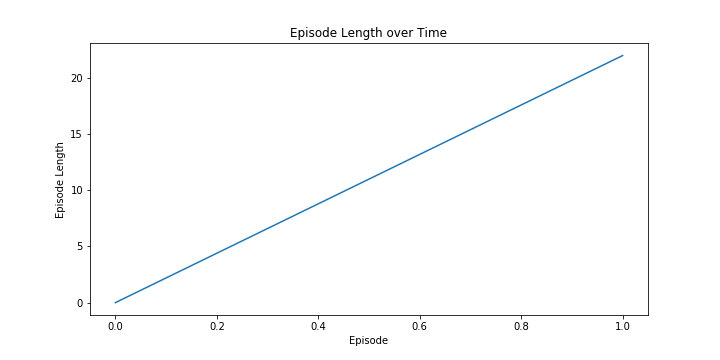

<IPython.core.display.Javascript object>


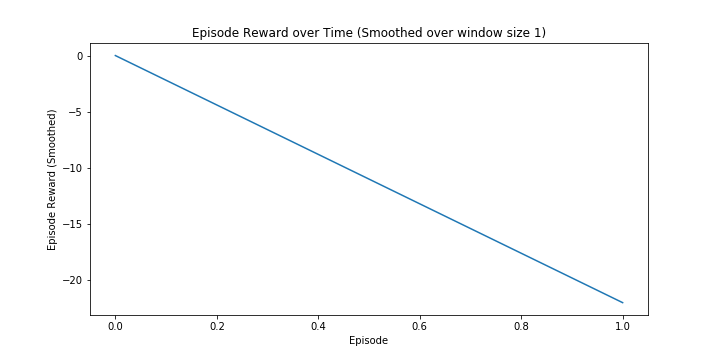

In [30]:
agent = DQNAgent(8 , 4*4)
experiment = Experiment(env, agent)
experiment.run_qlearning( max_number_of_episodes=1,  interactive = False, display_frequency=1)

In [6]:
a = [ [ 2,4] , [2,5] , [1,4] , [6,2]]

In [7]:
b = np.array(a)

In [35]:
b[0] = (3,14)

In [37]:
ccc = np.array( [ 3,14])

In [38]:
ccc

array([ 3, 14])

In [39]:
b[0] 

array([ 3, 14])

In [40]:
b[0] == ccc

array([ True,  True])

In [42]:
r1 , r2 = b[0]

In [43]:
r1

3

In [44]:
r2

14

In [5]:
b

NameError: name 'b' is not defined

In [21]:
np.all( b[0] == [2,1] )

False

In [17]:
b[0]

array([2, 4])